# NLP Assignment 7
Created by Prof. [Mohammad M. Ghassemi](https://ghassemi.xyz)

Submitted by: <span style="color:red"> INSERT YOUR NAME HERE </span>

In collaboration with: <span style="color:red"> INSERT YOUR (OPTIONAL) HOMEWORK PARTNER'S NAME HERE </span>

<hr> 

## Assignment Goals
The goal of this assignment is to familiarize yourself with:

1. Generating Audio
2. Visualizing Audio
3. Extracting Audio Features

This assignment combines tutorial components, with learning exercises that you must complete and submit. The learning exercise sections are clearly demarcated within the assignments.

## Before you start
1. PULL THE LATEST VERSION OF THE `course-materials` REPOSITORY, AND COPY `homework/HW7/` INTO THE CORRESPONDING DIRECTORY OF YOUR SUBMISSION FOLDER
2. CREATE AND ATTACH TO A VIRTUAL ENVIRONMENT, AND INSTALL THE REQUIREMENTS IN `requirements.txt`
3. IMPORT THE COURSE UTILITIES AND RELEVANT LIBRARIES BY RUNNING THE CODE BLOCK BELOW


In [2]:
import IPython

import numpy as np
import simpleaudio as sa
from pydub import AudioSegment
from pydub.playback import play


import numpy as np
import scipy.io.wavfile as wave
import python_speech_features as psf
from pydub import AudioSegment

import matplotlib.pyplot as plt
import sounddevice as sd
from scipy.io.wavfile import write
import ffprobe
import scipy
import matplotlib.pyplot as plt

/Users/ghamut/Documents/course-materials/homework/HW5/venv/lib/python3.7/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
/Users/ghamut/Documents/course-materials/homework/HW5/venv/lib/python3.7/site-packages/pydub/utils.py:184: RuntimeWarning: Couldn't find ffplay or avplay - defaulting to ffplay, but may not work
  warn("Couldn't find ffplay or avplay - defaulting to ffplay, but may not work", RuntimeWarning)


<hr> 

## Generating Audio in Python

<br>



In the code block below I provide an example of how to play a sound associated with a combination of sinusoidal frequencies.

In [3]:
#----------------------------------------------------------
# Function to generate sounds from frequencies
#----------------------------------------------------------
def makeSound(frequency, amplitude, fs, seconds):
    
    # The length of the sound is the number of seconds x number of samples per second.
    t     = np.arange(0,seconds, 1.0/fs) 

    # Sum the sinusoids to generate the sounds.
    for i,f in enumerate(frequency):
        note  = np.sin(f * t * 2.0 * np.pi)
        if i == 0:
            sound = note
        else:
            sound += amplitude[i] * note
    
    audio = sound * (2**15 - 1) / np.max(np.abs(sound))
    audio = audio.astype(np.int16)
    return audio

#----------------------------------------------------------
# Make a sound by mixing frequencies
#----------------------------------------------------------
audio = makeSound(frequency  = [200,100,50,400],
                  amplitude  = [2, 5 ,1 ,9],
                          fs = 44100, 
                     seconds = 0.5)

#----------------------------------------------------------
# Play the sound:
#----------------------------------------------------------
play_obj = sa.play_buffer(audio, 1, 2, 44100) 
play_obj.wait_done()


<hr> 

## Importing, Listening, and Visualizing Audio

<br> You can download publically available audio data in `.mp3` format from [LibriVox.org](ghttps://librivox.org/). Many of the libraries, including those we will be using for this tutorial, assume that the files will be in `.wav` format. For converting the files, I suggest [Audacity](https://www.audacityteam.org/download/), which you can also use for recording your own audio files directly to wav format.  For the purposes of this brief tutorial, I have included one audio file in `.wav` format which I downloaded from LibriVox.org in our directory. Let's load it using the librosa library.

In [1]:
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display

# Load the audio data into x, and retain the sampling rate - sr
x, sr = librosa.load('sugarplumtree.wav')

<br><br> We can play a segment of the audio directly within the notebook; let's do from 1 to 2.5 seconds:

In [2]:
from_time, to_time = 1, 2.5
segment = x[round(sr*from_time):round(sr * to_time)]
ipd.Audio(segment, rate=sr)

<br><br>We can also plot the raw audio waveform for the segment above to see what these waveforms look like:

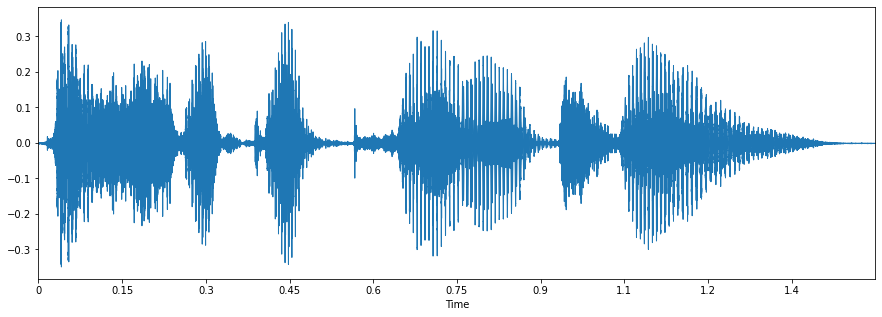

In [3]:
plt.figure(figsize=(15, 5))
librosa.display.waveplot(segment, sr=sr)

<br><br> The time domain characteristics provides some hints about how we might segment the text, but this will probably be easier to interpret once we see the spectrogram! It's easy to make mistakes when generating a spectrogram is we don't account for how our ears hears. To illustrate, let's do a fourier transform of the waveform above, and simply plot the resulting spectrogram with no further modifications:

/Users/ghamut/Documents/course-materials/homework/HW5/venv/lib/python3.7/site-packages/librosa/display.py:823: UserWarning: Trying to display complex-valued input. Showing magnitude instead.
  "Trying to display complex-valued input. " "Showing magnitude instead."


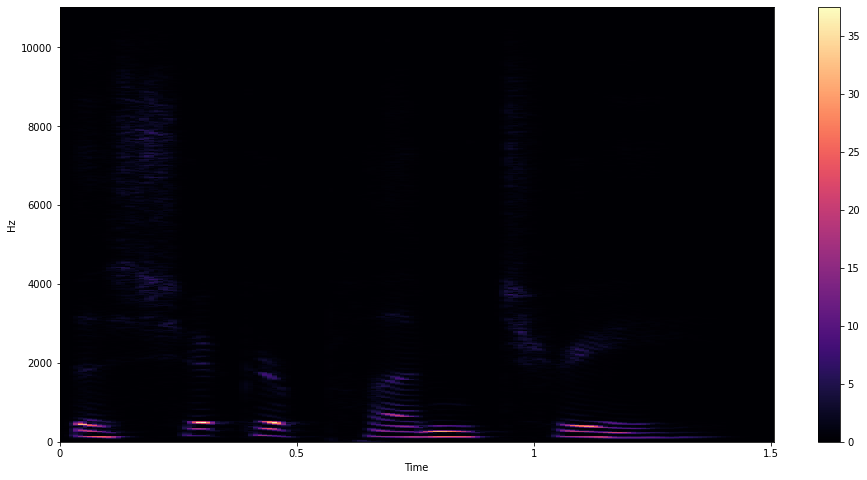

In [4]:
#-----------------------------------------------------------------
# Apply the Fourier Transform the signal to generate the spectrogram:
#-----------------------------------------------------------------
hop_length = int(sr * 0.01) # 10ms
n_fft      = int(sr * 0.05) # 50ms

X   = librosa.stft(segment, hop_length = hop_length,  # This is related to the overlap window we discussed in the lecture.
                            win_length = None,        # This is the size of the window, in samples. When None, it's computed automatically.
                            window     = 'hann',      # This is the window fucntion we discussed in the lecture.
                            n_fft      = n_fft)       # This is the DFT size we discs 

plt.figure(figsize=(16, 8))
librosa.display.specshow(X, sr         = sr, 
                            x_axis     = 'time', 
                            y_axis     = 'linear', 
                            hop_length = hop_length,
                            fmax       = 8000)
plt.colorbar()

<br><br> That doesn't look right! It's difficult to see what's going on here because the way that we hear sound in not linear. We need to account for that non-linearity. As we discussed in the lecture, our ears perceive sound on a log, not a linear scale. Furthermore, our ears do not perceive all frequencies similarly (i.e. we must convert to mel units). Let's make those corrections and plot the spectrogram again:

/Users/ghamut/Documents/course-materials/homework/HW5/venv/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/ghamut/Documents/course-materials/homework/HW5/venv/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


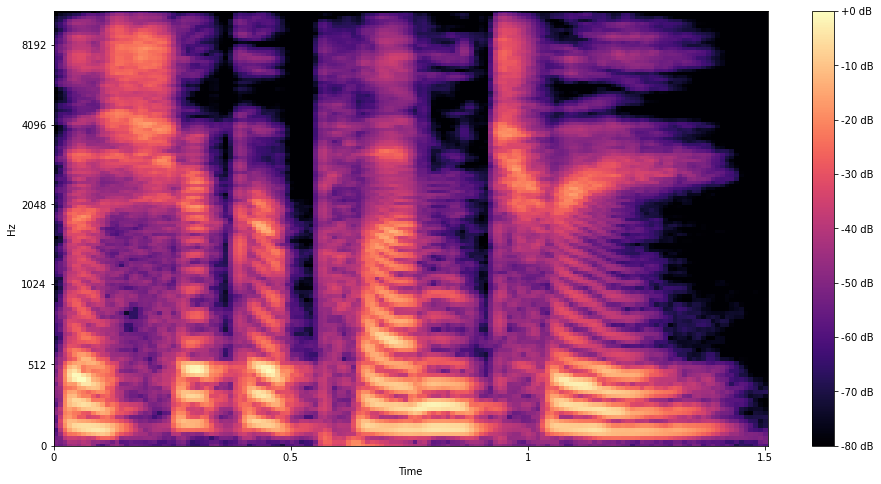

In [7]:
#-----------------------------------------------------------------
# Apply the Fourier Transform the signal to generate the spectrogram:
#-----------------------------------------------------------------
hop_length = int(sr * 0.01) # 10ms
n_fft      = int(sr * 0.05) # 50ms

# Compute the Spectrogram, with the mel adjustment
S = librosa.feature.melspectrogram(y= segment, hop_length = hop_length,  # This is related to the overlap window we discussed in the lecture.
                                               window     = 'hann',      # This is the window fucntion we discussed in the lecture.
                                               n_fft      = n_fft,       # This is the DFT size we discussed in the lecture. 
                                               n_mels     = 128 )        

#-----------------------------------------------------------------
# Convert from linear to lob scale
#-----------------------------------------------------------------
S_dB    = librosa.power_to_db(S, ref=np.max)

#-----------------------------------------------------------------
# Plot the spectrogram
#-----------------------------------------------------------------
plt.figure(figsize=(16, 8))
librosa.display.specshow(S_dB, x_axis     = 'time',
                               y_axis     = 'mel',
                               hop_length = hop_length,
                               sr         = sr)
plt.colorbar(format='%+2.0f dB')

<br><br>That's better! Note that the above plot is just a visualization of the data in the `Xdb` matrix, just as we discussed in the class; we can see the dimensions of the matrix here are quite reasonable relative to the raw waveform!  

In [17]:
np.shape(S_dB)

(128, 151)

<hr> 

## Audio Features

If we had some annotated data, we could train a machine learning model to take this these Spectrograms, and perform classification (e.g. score for sentiment, speaker identification), or do a sequence to sequence model to, for instance, generate text from the speech. 

While Neural networks take care of most feature extraction these days, we could also use extract some features manually; this is a good idea when our data sizes are on the smaller side. If you're interested in extracting features form this kind of data, there are some excellent online toolkits and [examples on how to use them](https://github.com/talhanai/acousticfeatures-fhs). To keep things simple, let's explore just a couple time-domain, and frequency domain features: 

### Time Domain

One thing we might be interested in understanding is the variance of the waveform in the time domain; the variance is a useful feature for identifying silent periods, which may indicate break points between words.

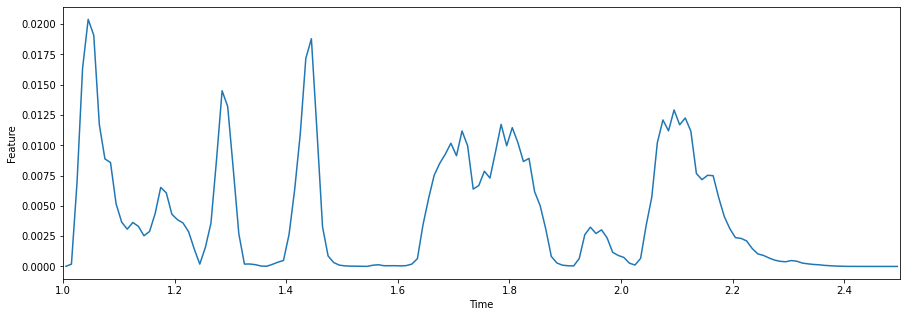

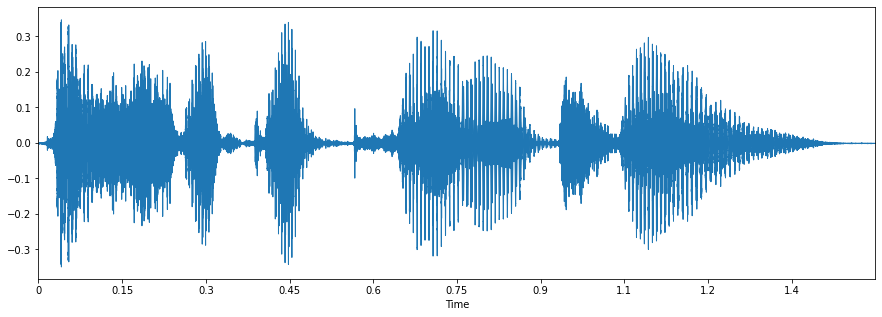

In [18]:
#-----------------------------------------------------------------
# Define a function that extracts variance from the 
#-----------------------------------------------------------------
def getVarianceFeature(x, sr, from_time, to_time, step_size, window_size):
    features,times  = [], []
    start, end = from_time,from_time + window_size
    while end < to_time:
        end     = start + window_size
        segment = x[round(sr*start):round(sr * end)]
        features.append(np.var(segment))
        times.append(start + step_size/2)
        start  += step_size
    return features, times 


# all times are in seconds
from_time   = 1 
to_time     = 2.5 
step_size   = 0.01 
window_size = 0.02  

# Get the variance feature
features, times = getVarianceFeature(x, sr, from_time, to_time, step_size, window_size)       

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(times, features)
plt.xlabel('Time')
plt.ylabel('Feature')
plt.xlim((from_time, to_time))
plt.show()

plt.figure(figsize=(15, 5))
librosa.display.waveplot(x[round(sr*from_time):round(sr * to_time)], sr=sr)

<br> Note that variance is not the only (or the "best") feature for segmenting the words in an audio file.


<br><br> Another useful time domain feature is the pitch, or fundamental frequency of the waveform. The pitch is extracted using the autocorrelation of a signal; autocorrelation describes the similarity of a signal against a time-shifted version of itself. Here's an example of how we can extract the pitch:

In [8]:
# Autocorrelate the segment 
r = librosa.autocorrelate(segment)
r = r[25:] # Remove high frequency components:

# Get the pitch
t_max = r.argmax()
pitch = float(sr)/t_max
print('Pitch in this segment:', round(pitch), 'Hz')

Pitch in this segment: 156 Hz


<br>Of course, you could place this pitch function within a moving window, as we did with the variance to extract pitch across the waveform. 

### Frequency Domain
There are also features that we can extract from the frequency domain characteristics embedded in the spectrogram. Let's take a look at a one such feature. To begin, we'll need an index that maps the indicies of our spectrogram matrix into the frequency values they describe:

In [20]:
#-------------------------------------------------------
# Let's get the shape of the Spectrogram data
#-------------------------------------------------------
np.shape(S_dB) # Notice it has 128 rows, one for each of the mel frequencies.

#-------------------------------------------------------
# Let's get the index that corresponds to each freqeuncy 
#-------------------------------------------------------
frequency_index = librosa.mel_frequencies(n_mels = 128)
len(frequency_index)

128

<br> Now, we can figure out, in each temporal segment of the spectrogram, which frequency component had the highest magnitude:

/Users/ghamut/Documents/course-materials/homework/HW5/venv/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)
/Users/ghamut/Documents/course-materials/homework/HW5/venv/lib/python3.7/site-packages/librosa/display.py:974: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  scaler(mode, **kwargs)


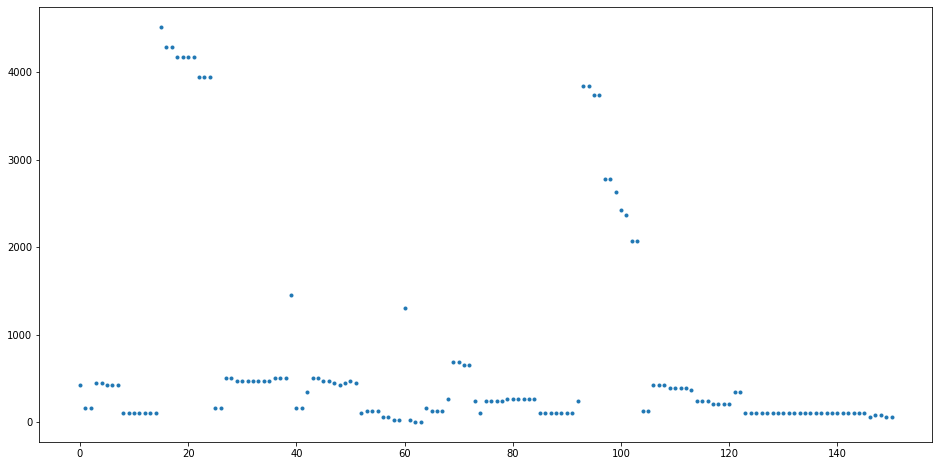

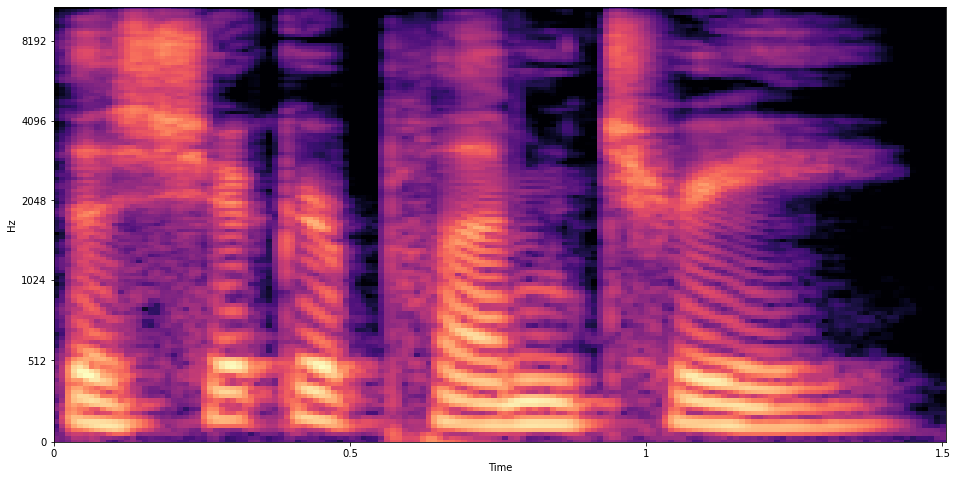

In [21]:
plt.figure(figsize=(16, 8))
plt.plot(frequency_index[np.argmax(S_dB,0)],'.')

plt.figure(figsize=(16, 8))
librosa.display.specshow(S_dB, x_axis = 'time', y_axis = 'mel',hop_length = hop_length,  sr = sr)

Notice that there are clear changes in the feature, especially when a high-frequency phone is uttered. 

<hr>

<br>

## Learning Exercise:


### A. Record, display and compare audio
Record an audio segment of yourself saying `the sugar plum tree`. Save the audio segment as a `.wav` file, import it into Python and plot the spectrogram. Compare the spectrogram of your voice against the spectrogram of the narrator from the tutorial. What differences do you observe in the time and frequency domain characteristics of your spectrogram compared to the narrator from the tutorial? How could you account for these differences if you wanted to train a speech-to-text system that worked for your audio, as well as the narrators?  


<span style="color:red"> INSERT YOUR ANSWER HERE </span>



### B. Speech Segmenter
Write a speech segmenter that breaks the speech in `sugarplumtree.wav`, and the speech you generated in part A into 4 audio segments each containing one word (`the`, `sugar`, `plum` and `tree`). You are welcome to the use any time or frequency domain characteristics that you think would be helpful for this problem. Your method doesn't have to perform perfectly, as long as it is well-reasoned. You can use external libraries to extract features, or write the features on your own, but the function for the segmenter must be built by you. 

In [22]:
################################################################################
# INSERT YOUR CODE HERE
# DO NOT FORGET TO PRINT YOUR MEANINGFUL RESULTS TO THE SCREEN.
################################################################################

<span style="color:red"> JUSTIFY THE RATIONAL FOR YOUR APPROACH </span>

### C. Phone Segmenter
Write a phone segmenter that breaks the speech in `sugarplumtree.wav`, and the speech you recorded in part A into its constituent phones. You are welcome to the use any time or frequency domain characteristics that you think would be helpful for this problem. Your algorithm doesn't have to perform perfectly, as long as it is well-reasoned. You can use external libraries to extract features, or write them on your own, but the function for the segmenter must be built by you. 

In [25]:
################################################################################
# INSERT YOUR CODE HERE
# DO NOT FORGET TO PRINT YOUR MEANINGFUL RESULTS TO THE SCREEN.
################################################################################

<span style="color:red"> INSERT AN INTERPRETATION OF YOUR RESULTS HERE </span>

<hr>
<h1><span style="color:red"> Self Assessment </span></h1>
Please provide an assessment of how successfully you accomplished the learning exercises in this assignment according to the instruction provided; do not assign yourself points for effort. This self assessment will be used as a starting point when I grade your assignments. Please note that if you over-estimate your grade on a given learning exercise, you will face a 50% penalty on the total points granted for that exercise. If you underestimate your grade, there will be no penalty.

* Learning Exercise: 
    * A. <span style="color:red">X</span>/1 points
    * B. <span style="color:red">X</span>/2 points
    * C. <span style="color:red">X</span>/2 points